In [311]:
import os
import numpy as np
import json
from skimage.draw import polygon
from PIL import Image
import matplotlib.pyplot as plt
from monai.losses import DiceLoss
from monai.networks.nets import UNet
from monai.networks.layers import Norm
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import time
import copy
from torchvision.io import read_image
from torchmetrics import Dice
import random

In [2]:
import json

with open('val.json', 'r') as f:
    data = json.load(f)

In [3]:
root = 'd:\\programming\\unet-livecell-project'
image_dir = r'D:\programming\unet-livecell-project\test_image\train_images'

### Process the masks based on .json file

In [4]:
# Get name of each image
image_name_list = []
files = os.listdir(image_dir)
for file in files:
    name, extension = os.path.splitext(file)
    if extension == '.tif':
        image_name_list.append(name)

In [5]:
image_id_to_segmentation = {}

# Collecting segmentation for each image_id
for image in data['images']:
    name, extension = os.path.splitext(image["file_name"])
    if name in image_name_list:
        image_id = image['id']
        segmentation_list = []
        for ann in data['annotations']:
            if ann['image_id'] == image_id:
                # Create a list of segmentation for each image, each list have corresponding (x, y) coordinate
                segmentation_list += ann['segmentation']
        image_id_to_segmentation[image_id] = {}
        image_id_to_segmentation[image_id]['segmentation'] = segmentation_list
        image_id_to_segmentation[image_id]['name'] = name

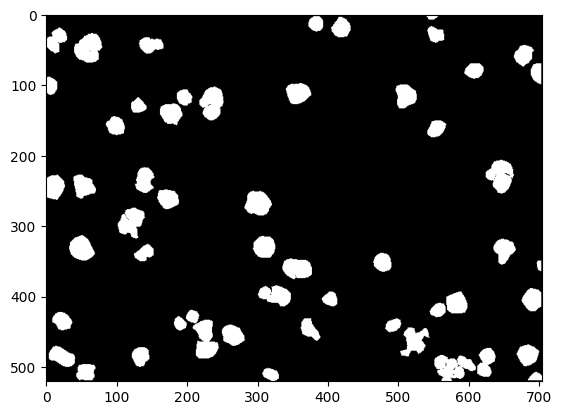

In [203]:
shape = (521, 705, 3)
# Create a mask for corresponding image id
for image_id in image_id_to_segmentation.keys():
    combined_mask = np.zeros(shape, dtype=np.float32)
    segmentation_list = image_id_to_segmentation[image_id]['segmentation']
    for segmentation in segmentation_list:
        mask = np.zeros(shape, dtype=np.bool8)
        rr, cc = polygon(segmentation[1::2], segmentation[0::2])
        mask[rr, cc] = 1
        # combined_mask += mask
        combined_mask = np.maximum(mask, combined_mask)
    name = image_id_to_segmentation[image_id]['name']
    plt.imshow(combined_mask, cmap='gray')
    # Save mask as gray scale image
    plt.imsave(rf'test_image/train_masks/{name}.png', combined_mask, cmap='gray')
    img_pil = Image.open(rf'test_image/train_masks/{name}.png')
    img_pil = img_pil.convert('L')
    img_pil.save(os.path.join(root, rf'test_image/train_masks/{name}.png'))

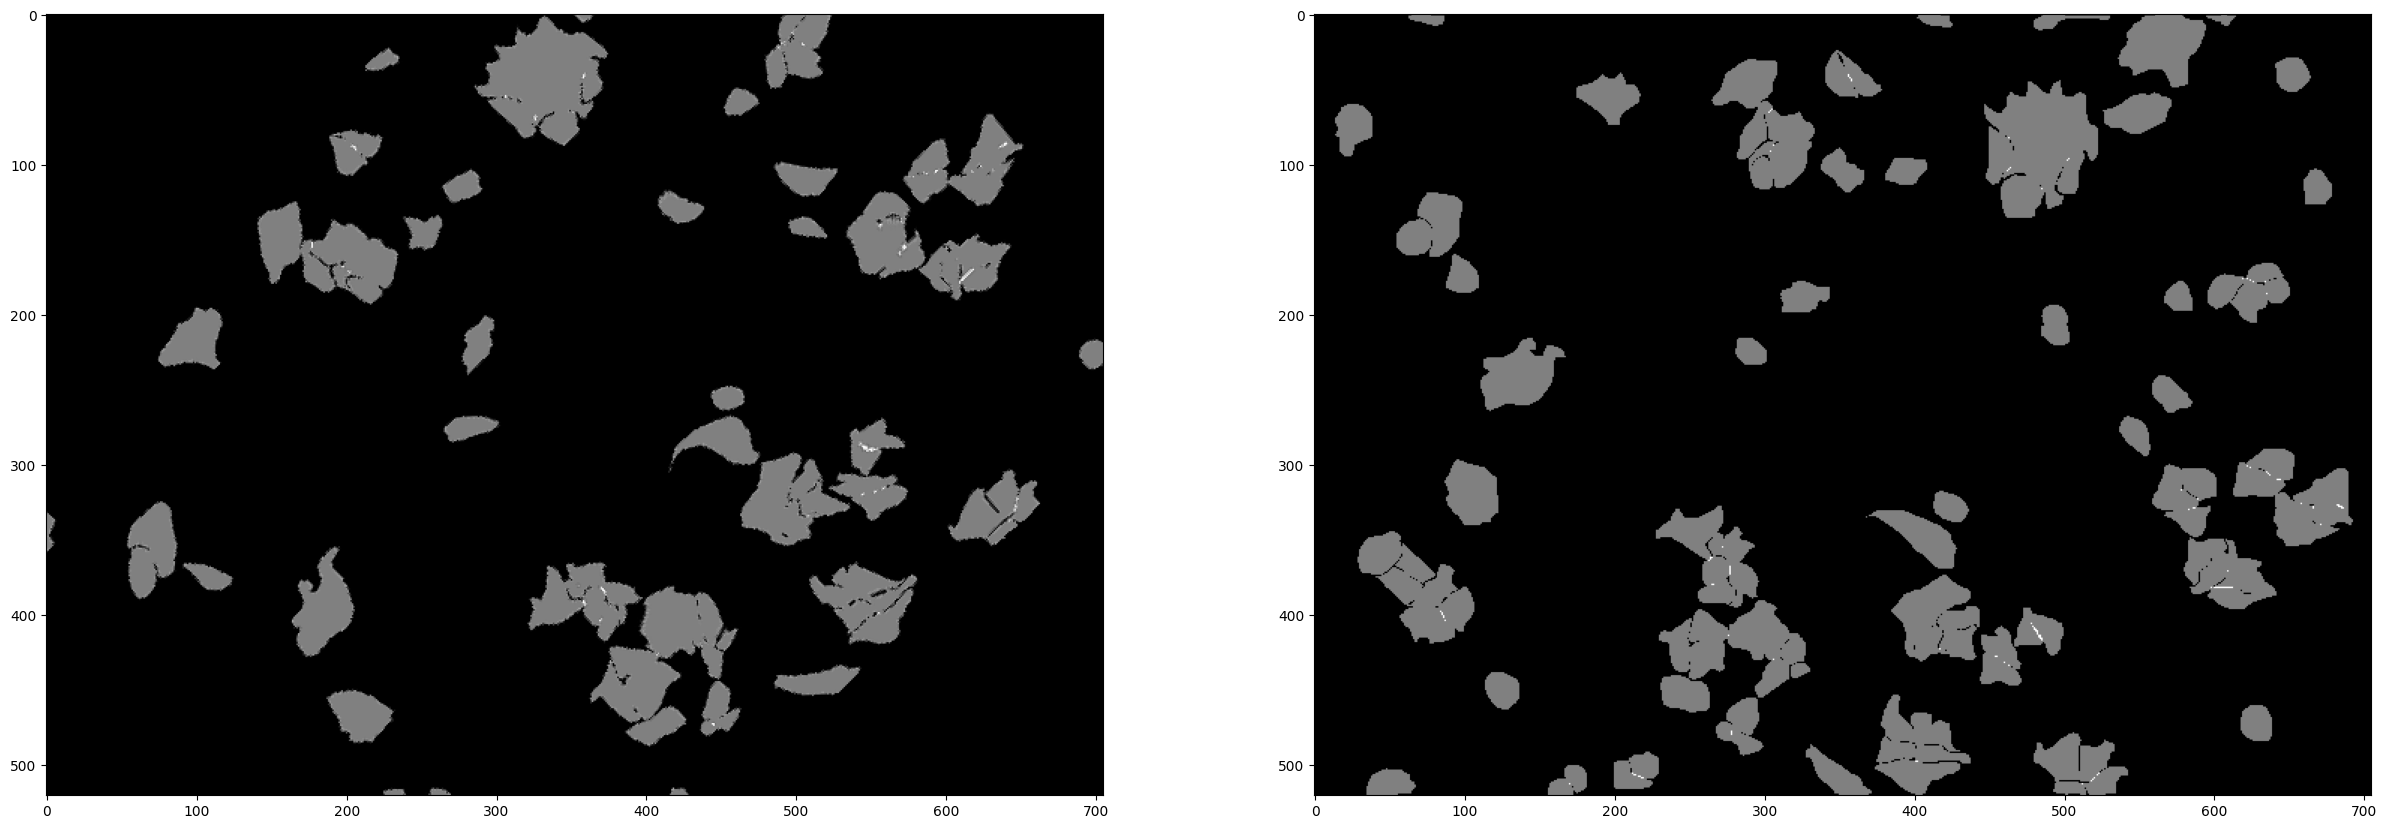

In [398]:
import Augmentor

# Load the image and convert it to a PyTorch tensor
p = Augmentor.Pipeline()
# p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.random_distortion(probability=1, grid_width=20, grid_height=20, magnitude=10)
mask = Image.open(r'D:\programming\unet-livecell-project\dataset\train_images\MCF7_Phase_E4_1_00d08h00m_1.png')
transform = transforms.Compose([
    p.torch_transform(),
    transforms.RandomRotation((-50, 50)),
    transforms.ToTensor()])
mask_tensor = transform(mask)
mask_tensor = mask_tensor.permute(1, 2, 0)
img = Image.open(r'D:\programming\unet-livecell-project\dataset\train_masks\MCF7_Phase_E4_1_00d08h00m_1.png')
img_tensor = transform(img)
img_tensor = img_tensor.permute(1,2,0)
fig, ax = plt.subplots(1, 2, figsize=(30,60))
ax[0].imshow(img_tensor, cmap='gray')
ax[1].imshow(img, cmap='gray')




In [40]:
# Transform all the images to gray scale images
def transform_image(folder, save_folder, json_file):
    file_name_list = []
    for image in json_file['images']:
        file_name = image["file_name"]
        name, extension = os.path.splitext(file_name)
        file_name_list.append(name)
    for image in os.listdir(folder):
        name, extension = os.path.splitext(image)
        if name in file_name_list:
            img_path = os.path.join(folder, image)
            image = Image.open(img_path)
            image = image.convert('L')
            image.save(f'{save_folder}/{name}.png')
# image_dir = r'D:\programming\unet-livecell-project\images\livecell_test_images'
save_folder = r'D:\programming\unet-livecell-project\test_image\train_images'
transform_image(image_dir, save_folder=save_folder, json_file=data)
            

In [1]:
import os
import numpy as np
import json
from skimage.draw import polygon
from PIL import Image
import matplotlib.pyplot as plt
from monai.losses import DiceLoss
from monai.networks.nets import UNet
from monai.networks.layers import Norm
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import time
import copy
from torchvision.io import read_image
from torchmetrics import Dice
import cv2

d:\programming\transformer\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        # self.to("cuda")
        
    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


In [310]:
class Dataset():
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images_list = os.listdir(image_dir)
        self.images = self.images_list

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        
        image = Image.open(img_path)
        image = np.array(image.convert('RGB'))
        
        mask = Image.open(mask_path)
        mask = np.array(mask.convert('L'))
        
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

In [1081]:
class Dataset():
    def __init__(self, image_dir, mask_dir, normal_transform=None, augmentation_transform=None, train = False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.normal_transform = normal_transform
        self.augmentation_transform = augmentation_transform
        self.images = os.listdir(image_dir)
        self.train = train
    def __len__(self):
        if self.train is True:
            return len(self.images) * 2
        else:
            return len(self.images)
    def __getitem__(self, index):
        if self.train is True:
            img_path = os.path.join(self.image_dir, self.images[index])
            mask_path = os.path.join(self.mask_dir, self.images[index])
            
            image = Image.open(img_path)
            image = np.array(image.convert('RGB'))
            
            mask = Image.open(mask_path)
            mask = np.array(mask.convert('L'))
            
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
            
            if index % 2 == 0:
                # Apply normal transform
                if self.normal_transform:
                    image = self.normal_transform(image)
                    mask = self.normal_transform(mask)
            else:
                # Apply augmentation transform
                if self.augmentation_transform:
                    image = self.augmentation_transform(image)
                    mask = self.augmentation_transform(mask) 
        else:
            img_path = os.path.join(self.image_dir, self.images[index])
            mask_path = os.path.join(self.mask_dir, self.images[index])
            
            image = Image.open(img_path)
            image = np.array(image.convert('RGB'))
            
            mask = Image.open(mask_path)
            mask = np.array(mask.convert('L'))
            
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
            
            if self.normal_transform:
                image = self.normal_transform(image)
                mask = self.normal_transform(mask)
                
        return image, mask
    


In [1441]:
class Dataset():
    def __init__(self, image_dir, mask_dir, normal_transform=None, augmentation_transform=None, train = False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.normal_transform = normal_transform
        self.augmentation_transform = augmentation_transform
        self.train = train
        self.images = os.listdir(image_dir)
    def __len__(self):
        if self.train is True:
            self.images = os.listdir(self.image_dir) * 2
            return len(self.images)
        else:
            self.images = os.listdir(self.image_dir)
            return len(self.images)

    def __getitem__(self, index):
        random_seed = 42
        random.seed(random_seed)
        np.random.seed(random_seed)
        if self.train is True:
            img_index = index % len(self.images)
            if index < len(self.images)//2:
                img_path = os.path.join(self.image_dir, self.images[img_index])
                mask_path = os.path.join(self.mask_dir, self.images[img_index])
                image = Image.open(img_path)
                image = image.convert('RGB')
                
                mask = Image.open(mask_path)
                mask = mask.convert('L')
                
                # image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
                # mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
                if self.normal_transform:
                    image = self.normal_transform(image)
                    mask = self.normal_transform(mask)
            else:
                img_path = os.path.join(self.image_dir, self.images[img_index])
                mask_path = os.path.join(self.mask_dir, self.images[img_index])
            
                image = Image.open(img_path)
                image = image.convert('RGB')
                
                mask = Image.open(mask_path)
                mask = mask.convert('L')
                
                # image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
                # mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
            
                if self.augmentation_transform:
                    image = self.augmentation_transform(image)
                    mask = self.augmentation_transform(mask) 
                    mask = mask.point(lambda x: 0 if x < 127 else 255)
                
        else:
            img_path = os.path.join(self.image_dir, self.images[index])
            mask_path = os.path.join(self.mask_dir, self.images[index])
            
            image = Image.open(img_path)
            image = image.convert('RGB')
            
            mask = Image.open(mask_path)
            mask = mask.convert('L')
            
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
            
            if self.normal_transform:
                image = self.normal_transform(image)
                mask = self.normal_transform(mask)
        
        transform = transforms.ToTensor()
        image = transform(image)
        mask = transform(mask)
        return image, mask
    


In [1442]:

TRAIN_IMG_DIR = r"D:\programming\unet-livecell-project\dataset\train_images"
TRAIN_MASK_DIR = r"D:\programming\unet-livecell-project\dataset\train_masks"
VAL_IMG_DIR = r"D:\programming\unet-livecell-project\dataset\val_images"
VAL_MASK_DIR = r"D:\programming\unet-livecell-project\dataset\val_masks"
TEST_IMG_DIR = r"D:\programming\unet-livecell-project\dataset\test_images"
TEST_MASK_DIR = r"D:\programming\unet-livecell-project\dataset\test_masks"

# TRAIN_IMG_DIR = r"D:\programming\unet-livecell-project\test_image\train_images"
# TRAIN_MASK_DIR = r"D:\programming\unet-livecell-project\test_image\train_masks"
# VAL_IMG_DIR = r"D:\programming\unet-livecell-project\test_image\train_images"
# VAL_MASK_DIR = r"D:\programming\unet-livecell-project\test_image\train_masks"

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

IMAGE_HEIGHT = 333  # 293 originally
IMAGE_WIDTH = 434 # 392 originally
EPOCHS = 30
LEARNING_RATE = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = UNET()
model.to(DEVICE)
p = Augmentor.Pipeline()
p.random_distortion(probability=1, grid_width=random.randint(1,3) * 10, grid_height=random.randint(1,3) * 10, magnitude=random.randint(1,3) * 10)
train_normal_transforms = torchvision.transforms.Compose(
    [   
        # transforms.ToPILImage(),
        transforms.Resize((IMAGE_HEIGHT,IMAGE_WIDTH)),
        # transforms.ToTensor(),      
    ],
)
# train_augmentation_transforms = torchvision.transforms.Compose([ 
#         transforms.ToPILImage(),
#         transforms.Resize((IMAGE_HEIGHT,IMAGE_WIDTH)),        
#         p.torch_transform(),
#         transforms.ToTensor(),      
#     ],
# )
transform = transforms.ToTensor()
val_transforms = torchvision.transforms.Compose(
    [   
        # transforms.ToPILImage(),
        transforms.Resize((IMAGE_HEIGHT,IMAGE_WIDTH)),
        # transforms.ToTensor(),
    ],
)

test_transforms = torchvision.transforms.Compose(
    [
        # transforms.ToPILImage(),
        transforms.Resize((IMAGE_HEIGHT,IMAGE_WIDTH)),
        # transforms.ToTensor(),
    ]
)
train_ds = Dataset(image_dir=TRAIN_IMG_DIR, mask_dir=TRAIN_MASK_DIR, normal_transform= train_normal_transforms, augmentation_transform= train_augmentation_transforms, train=True)
val_ds = Dataset(image_dir=VAL_IMG_DIR, mask_dir=VAL_MASK_DIR, normal_transform= val_transforms)
test_ds = Dataset(image_dir=TEST_IMG_DIR, mask_dir=TEST_MASK_DIR, normal_transform=test_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=2, shuffle=True)

loss_fn = DiceLoss(sigmoid=True,squared_pred=True)
# loss_fn = nn.BCELoss() #RuntimeError: Unable to find a valid cuDNN algorithm to run convolution
# loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5, amsgrad=True)

In [1443]:
from PIL import ImageOps
img_path = r'D:\programming\unet-livecell-project\test_image\train_images\A172_Phase_A7_1_00d00h00m_1.png'
mask_path = r'D:\programming\unet-livecell-project\test_image\train_masks\A172_Phase_A7_1_00d00h00m_1.png'
train_augmentation_transforms = torchvision.transforms.Compose([ 
        transforms.Resize((IMAGE_HEIGHT,IMAGE_WIDTH)),        
        p.torch_transform(),   
    ],
)
image = Image.open(img_path)
image = image.convert('RGB')

mask = Image.open(mask_path)
mask = mask.convert('L')

# image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
# mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

image = train_augmentation_transforms(image)
mask = train_augmentation_transforms(mask) 

binary_image = mask.point(lambda x: 0 if x < 127.5 else 255)
binary_image
transform = transforms.ToTensor()
mask = transform(mask)
# mask = np.array(mask.convert('L'))
# mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
# plt.imshow(mask.permute(1,2,0), cmap='gray')
# fig, ax = plt.subplots(1, 2, figsize=(30,60))
# ax[0].imshow(image.permute(1,2,0), cmap='gray')
# ax[1].imshow(mask, cmap='gray')


In [1405]:
torch.cuda.empty_cache()
print(len(train_ds))
print(len(os.listdir(r'D:\programming\unet-livecell-project\dataset\train_images')))

6376
3188


In [1206]:
(images, masks) = next(iter(train_loader))
images.shape

torch.Size([2, 3, 333, 434])

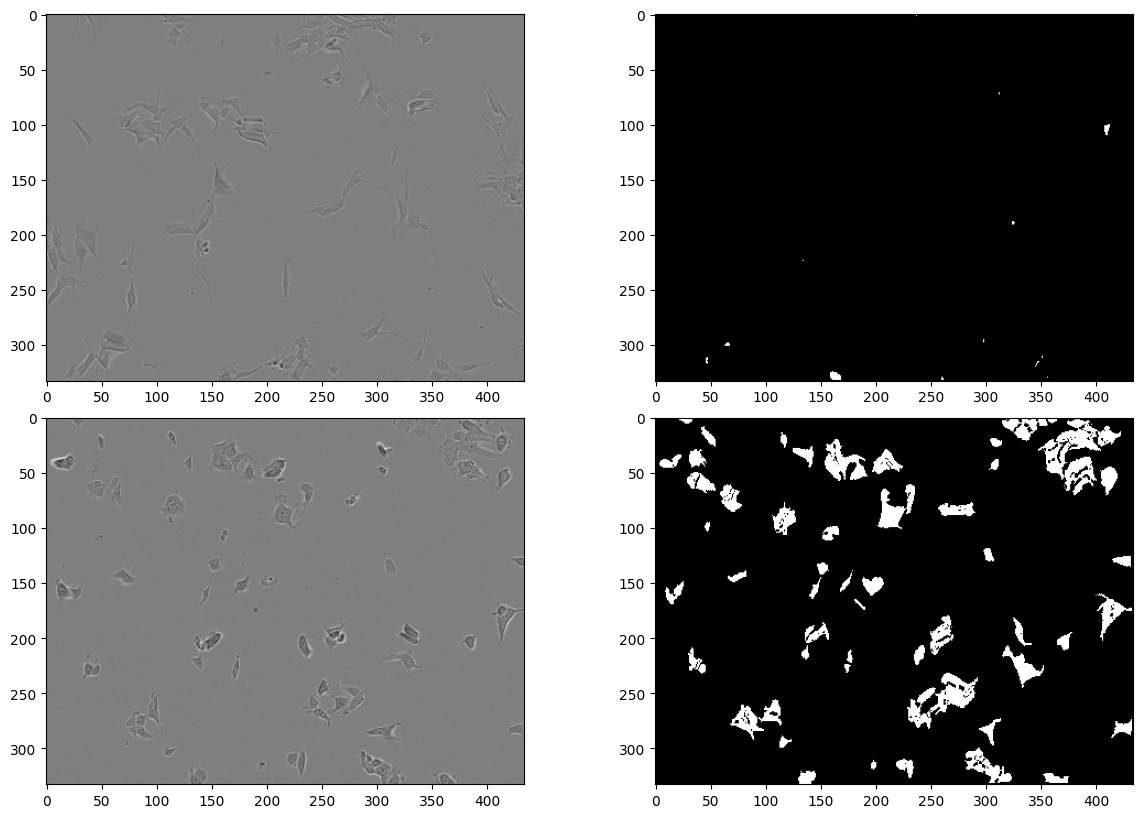

In [1444]:
import matplotlib.gridspec as gridspec

(images, masks) = next(iter(train_loader))

fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.1, hspace=0.1)

ax = plt.subplot(gs[0, 0])
ax.imshow(images[0].permute(1, 2, 0), cmap='gray')
ax = plt.subplot(gs[0, 1])
ax.imshow(masks[0].permute(1, 2, 0), cmap='gray')

ax = plt.subplot(gs[1, 0])
ax.imshow(images[1].permute(1, 2, 0), cmap='gray')
ax = plt.subplot(gs[1, 1])
ax.imshow(masks[1].permute(1, 2, 0), cmap='gray')

# show the plot
plt.show()


In [479]:
train_loss_list = []
val_loss_list = []
since = time.time()
# best_model_wts = copy.deepcopy(model.state_dict())
smallest_loss = 1.0
for epoch in range(EPOCHS):
    # Train
    train_epoch_loss = 0.0
    for idx, (image, mask) in enumerate(train_loader):
        image = image.to(device=DEVICE)
        mask = mask.to(device=DEVICE)
        optimizer.zero_grad()
        prediction = model(image)
        
        loss = loss_fn(prediction, mask)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
    epoch_loss = train_epoch_loss/len(train_loader)
    # if (idx+1) % 10 == 0:
    print("Epoch [{}/{}], Step [{}/{}], train_loss: {:.4f}".format(epoch+1, EPOCHS, idx+1, len(train_loader), epoch_loss))
    train_loss_list.append(epoch_loss)
    # Val
    with torch.no_grad():
        val_loss = 0.0
        for idx, (image, mask) in enumerate(val_loader):
            image = image.to(device=DEVICE)
            mask = mask.to(device=DEVICE)
            prediction = model(image)
            
            loss = loss_fn(prediction, mask)
            val_loss += loss.item()
        epoch_loss = val_loss/len(val_loader)
        print("Epoch [{}/{}], Step [{}/{}], val_loss: {:.4f}".format(epoch+1, EPOCHS, idx+1, len(val_loader), epoch_loss))
        if epoch_loss < smallest_loss:
            smallest_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        val_loss_list.append(epoch_loss)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
print('Smallest val loss: {:4f}'.format(smallest_loss))

Epoch [1/30], Step [3188/3188], train_loss: 0.3457
Epoch [1/30], Step [285/285], val_loss: 0.1660
Epoch [2/30], Step [3188/3188], train_loss: 0.2998
Epoch [2/30], Step [285/285], val_loss: 0.1351
Epoch [3/30], Step [3188/3188], train_loss: 0.2865
Epoch [3/30], Step [285/285], val_loss: 0.1131
Epoch [4/30], Step [3188/3188], train_loss: 0.2810
Epoch [4/30], Step [285/285], val_loss: 0.1052
Epoch [5/30], Step [3188/3188], train_loss: 0.2761
Epoch [5/30], Step [285/285], val_loss: 0.0997
Epoch [6/30], Step [3188/3188], train_loss: 0.2731
Epoch [6/30], Step [285/285], val_loss: 0.0951
Epoch [7/30], Step [3188/3188], train_loss: 0.2707
Epoch [7/30], Step [285/285], val_loss: 0.0943
Epoch [8/30], Step [3188/3188], train_loss: 0.2698
Epoch [8/30], Step [285/285], val_loss: 0.0969
Epoch [9/30], Step [3188/3188], train_loss: 0.2673
Epoch [9/30], Step [285/285], val_loss: 0.0887
Epoch [10/30], Step [3188/3188], train_loss: 0.2664
Epoch [10/30], Step [285/285], val_loss: 0.0876
Epoch [11/30], Ste

In [480]:
torch.save(best_model_wts, 'model/model_augmented_diceloss.pth')

In [481]:
performance = {}
performance["train_loss"] = train_loss_list
performance["val_loss"] = val_loss_list

In [482]:
with open('performance_best_augmented_diceloss.txt', 'w') as f:
    f.write(str(performance))

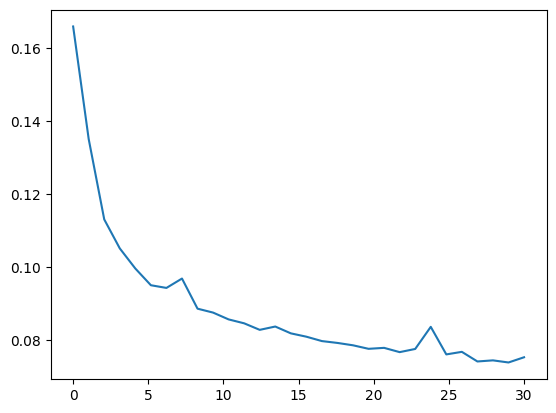

In [484]:
x = np.linspace(0, EPOCHS, EPOCHS)
plt.plot(x, val_loss_list)

In [571]:
model = UNET()
state_dict = torch.load('model/best_model_333_434_batch2.pth')
model.load_state_dict(state_dict)
model.to(device=DEVICE)


UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [572]:
with torch.no_grad():
    val_loss = 0.0
    total_loss = 0.0
    for idx, (image, mask) in enumerate(test_loader):
        image = image.to(device=DEVICE)
        mask = mask.to(device=DEVICE)
        prediction = model(image)
        
        loss = loss_fn(prediction, mask)
        val_loss += loss.item()
    total_loss = val_loss/len(test_loader)

In [573]:
total_loss

0.0684906282122173

tensor(0.5118, device='cuda:0')


Text(0.5, 1.0, 'ground truth')

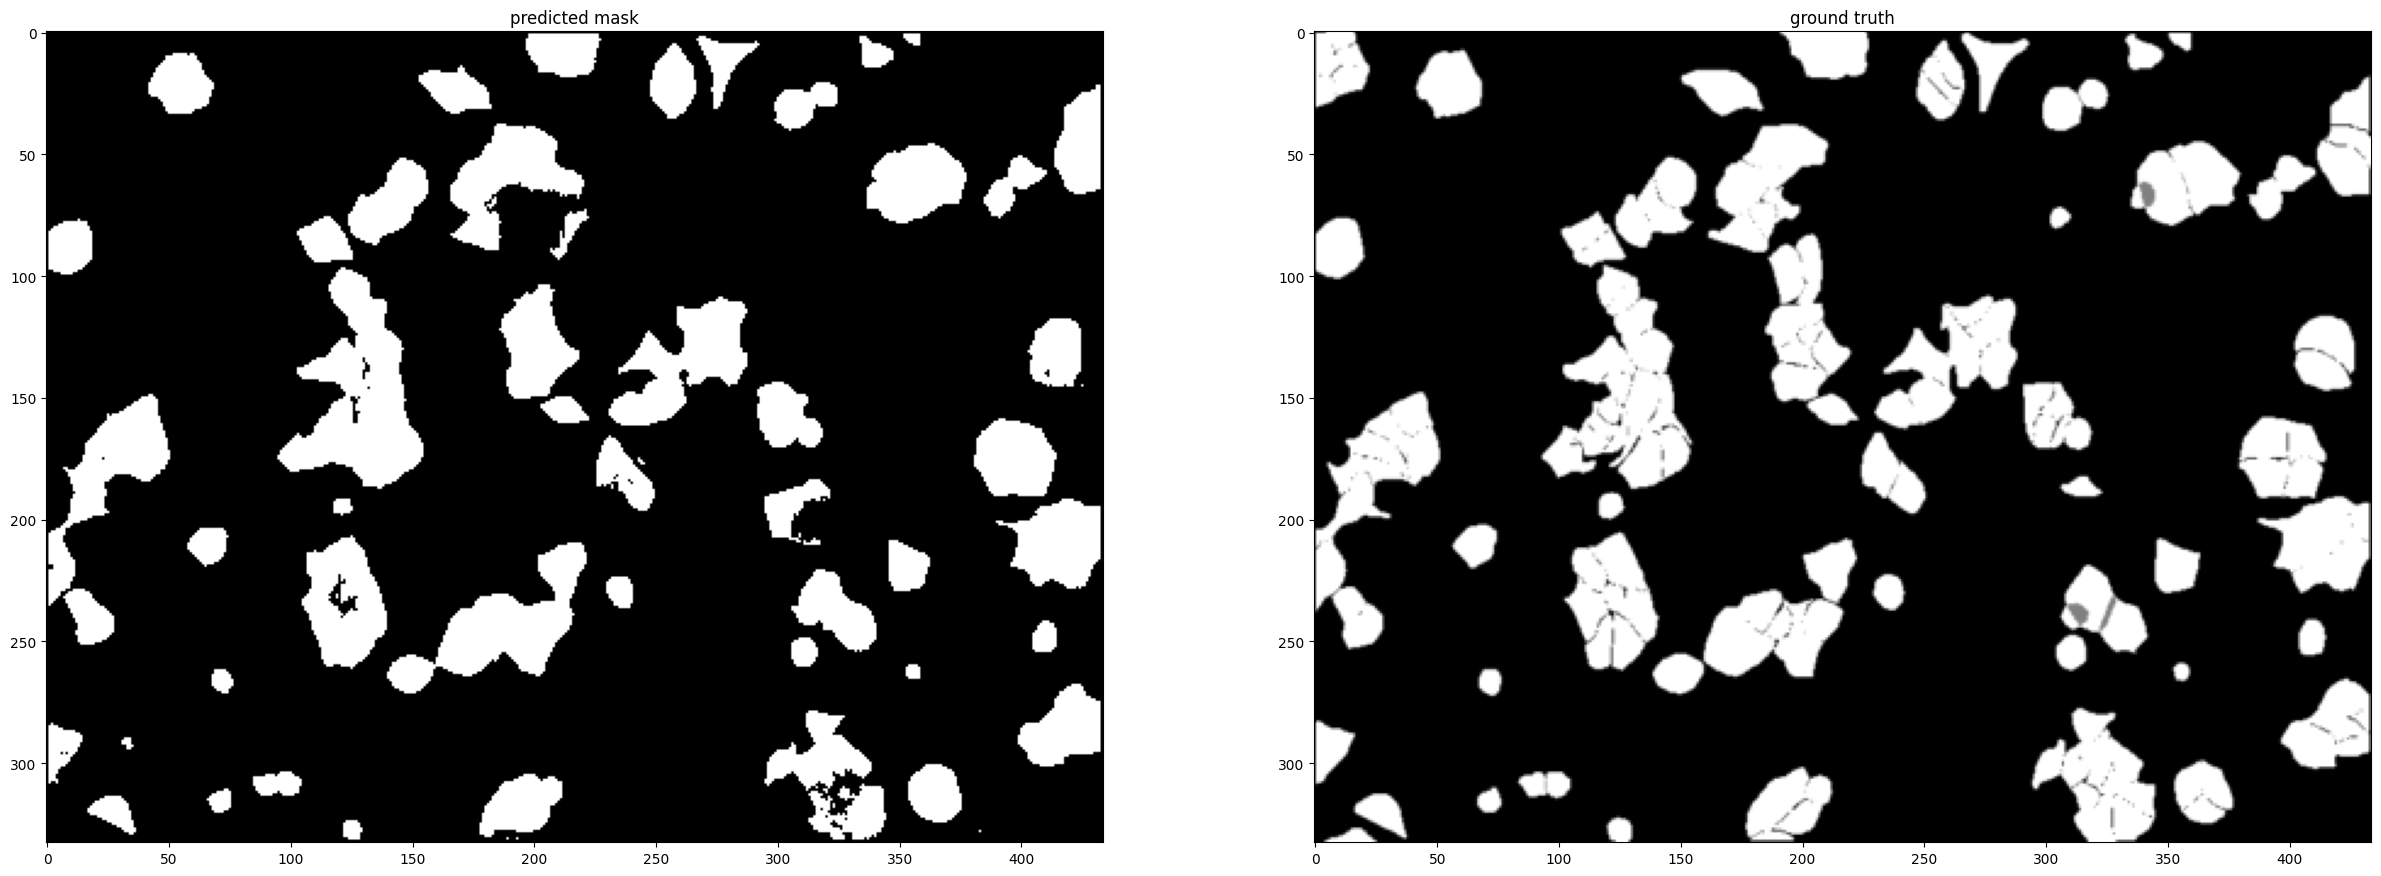

In [577]:
DEVICE='cuda'
model.to(DEVICE)
model.eval()
input, mask = next(iter(test_loader))
image = input[1].unsqueeze(0)
image = image.to(DEVICE)
mask = mask.to(DEVICE)
preds = torch.sigmoid(model(image))
preds = (preds > 0.5).float()
print(loss_fn(preds, mask[1].unsqueeze(0)))
preds = preds.cpu()
preds = preds.squeeze(0).squeeze(0)
mask = mask[1].squeeze(0).cpu()
fig, ax = plt.subplots(1, 2, figsize=(30,60))
ax[0].imshow(preds, cmap='gray')
ax[0].set_title('predicted mask')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('ground truth')
